In [1]:
import numpy as np
%pylab
%matplotlib inline

from Functions import functions as f
import skimage.io as sk
from collections import Counter


Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [69]:
img = sk.imread("Data/N2DH-GOWT1/img/t01.tif") #Bild laden
#f.show_image(img, 15, 8)


In [70]:

def seeds(img, T1, T2): # automatic seed selection algorithm
    result = np.zeros(img.shape)
    sd_seeds = f.standarddeviation(img,3) # standard deviation
    sd_flat = sd_seeds.flatten() # standard deviation as 1D-array
    similarity_seeds = 1 - sd_seeds/max(sd_flat) # calculates similarity of every pixel to its neighbors
    eurel_seeds = f.euclidean_relative(img, 3) # relative euclidean distance of every pixel to its neighbors
    for p in np.ndindex(img.shape): # border pixel value is zero
        if similarity_seeds[p] > T1 and eurel_seeds[p] < T2: # compares pixel with threshold
            result[p] = 1 # assigns value 1 to seeds
    return result

#Achtung auch Randpixel bekommen Wert 1 und sind somit immer seeds! In seed_merging werden diese jedoch wieder als seeds entfernt.
#Fehler Testbild, keine Seeds im Hintergrund gefunden, überprüfen!


#seed_final = seeds(img, 0.4, 40)
#f.show_image(seed_final, 15, 8)



In [71]:
def seed_merging(img):
    regions = np.zeros(img.shape) #creates new array for region numbers for every image pixel
    count = 1 #keep track of region number
    for p in np.ndindex(img.shape): #iterates over every pixel of the image
        if img[p] == 1: #tests if pixel is seed
            if p[0]-1 >= 0 and p[1]-1 >= 0 and p[0]+1 <= img.shape[0] -1 and p[1]+1 <= img.shape[1] -1: # no calculation of border pixels
                for q in np.ndindex(3, 3): # iterates over 3x3 neighborhood
                    i = p[0]-1 + q[0]
                    j = p[1]-1 + q[1]
                    if regions[i,j] != 0: #tests if neighbors are also seeds
                        regions[p] = regions[i,j] # merge neighboring seeds; wird zur letzten abgefragten Region zugeordnet
                if regions[p] == 0: #tests if no neighbors are seeds
                    regions[p] = count #creates new region from new seed
                    count += 1
    return regions

#test = seed_merging(seeds(f.img_resize(img, 500, 500), 0.4, 40))
#print(test)

In [72]:
#reduce number of starting regions for region growing by only considering starting regions with more than T seeds
def decrease_region_number(img, T):
    l = Counter(img.flatten()) #counts number of seeds in region
    d_seeds = img.copy() 
    for i in range(1, int(np.amax(img))): #iterates over every region
        if l[i] <= T:#if number of seeds is smaller than threshold, delete region
            for p in np.ndindex(img.shape):
                if img[p] == i:
                    d_seeds[p] = 0
    return d_seeds

#test2 = decrease_region_number(test, 10)
#f.show_image(test2, 15, 8)

In [73]:
#test3 = decrease_region_number(test, 50)
#f.show_image(test3, 15, 8)

In [74]:
def find_neighbors(regions):
    Ne = []
    for p in np.ndindex(regions.shape):
        if regions[p] != 0: # Pixels with region
            if p[0] > 0: # Add neighbours to list T, left
                a = (p[0]-1, p[1])
                if regions[a] == 0 and a not in Ne:
                    Ne.append(a)
            if p[0] < regions.shape[0]-1: # Add neighbours to list T, right
                b = (p[0]+1, p[1])
                if regions[b] == 0 and b not in Ne:
                    Ne.append(b)
            if p[1] > 0: # Add neighbours to list T, up
                c = (p[0], p[1]-1)
                if regions[c] == 0 and c not in Ne:
                    Ne.append(c)
            if p[1] < regions.shape[1]-1: # Add neighbours to list T, down
                d = (p[0], p[1]+1)
                if regions[d] == 0 and d not in Ne:
                    Ne.append(d)
    return Ne

In [75]:
#neighbors = find_neighbors(test3)
#print(neighbors)

In [76]:
def add_neighbors(img, p): #p describes pixel for which neighbors need to be added
    Ne1 = []
    if p[0] > 0: # Add neighbours to list T, up
        a = (p[0]-1, p[1])
        Ne1.append(a)
    if p[0] < img.shape[0]-1: # Add neighbours to list T, down
        b = (p[0]+1, p[1])
        Ne1.append(b)
    if p[1] > 0: # Add neighbours to list T, left
        c = (p[0], p[1]-1)
        Ne1.append(c)
    if p[1] < img.shape[1]-1: # Add neighbours to list T, right
        d = (p[0], p[1]+1)
        Ne1.append(d)
    return Ne1  #returns list of all existing direct neighbors (maximum 4 pixels)

In [77]:
def mean_region(img, regions): #img is array of intensity values, regions is array with region numbers
    mean_value = []
    region_max = int(max(regions.flatten())) #calculates amount of regions
    for count in range(1,region_max + 1): # iterates over every region
        intensity = []
        for p in np.ndindex(img.shape):
            if regions[p] == count:
                intensity.append(img[p]) #iterates over every pixel in the image and appends intensity value, if it is in the region
        mean_value.append(np.mean(intensity)) #calculates mean value of region
    return mean_value #returns list with average of every region

In [78]:
def mean_region_new(img, regions):
    mean_value = []
    region_max = int(max(regions.flatten()))
    intensity = []
    for i in np.ndindex(img.shape):
        intensity[regions[i]] = img[i]

# Idee schneller: einmal über Bild iterieren und Intensitätswerte in verschachtelte Liste schreiben
# Mittelwerte der Elemente der verschachtelten Liste berechnet

In [79]:
# calculated mean value of region of newly labeled pixel
def one_region_mean(img, regions, new_pixel): #img is array of intensity values, regions is array with region numbers, new_pixel is position of last added pixel
    intensity = []
    for p in np.ndindex(img.shape):
        if regions[p] == regions[new_pixel]: # finds region of newly added pixel
            intensity.append(img[p]) #iterates over every pixel in the image and appends intensity value, if it is in the region
    single_mean = np.mean(intensity) #calculates mean value of region with new pixel
    return single_mean #returns mean value of changed region

In [ ]:
# calculated mean value of region of newly labeled pixel
def one_region_mean2(img, regions, new_pixel): #img is array of intensity values, regions is array with region numbers, new_pixel is position of last added pixel
    intensity = []
    pos_new_reg = np.where(regions == new_pixel)
    pos_new_reg = list(zip(pos_new_reg[0], pos_new_reg[1]))
    single_mean = np.mean(img[pos_new_reg])
    return single_mean #returns mean value of changed region

In [2]:
y = np.zeros((3,3))
y[(0,1)] = 1
y[(1,1)] = 1
pos = np.where(y==1)
pos = list(zip(pos[0], pos[1]))
a = y[pos]
print(a)


[1. 1.]


C:\Users\marie\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [80]:
def calculation_distance(img, Ne, regions): # img intensity values, regions is region number, Ne is list of neighbours
    max_intensity = np.amax(img)
    means = mean_region(img, regions) # list of mean values of every region
    result = np.ones(img.shape) # new array with distance values, standard value is one
    nearest_reg = np.zeros(img.shape)
    for i in Ne:
        nei = add_neighbors(img, i) # list 4 neighbors of pixel i out of unsorted neighbors list
        distance = []
        region_number = []
        for j in nei:
            if regions[j] != 0: # only neighboring pixels which are sorted
                distance.append(np.abs((img[i] - means[int(regions[j]-1)])) / max_intensity) # saves tuple of normalized distance of pixel to neighbor j and region of j
                region_number.append(regions[j])
        min_dist = min(distance)  # saves minimal distance to 1 of its neighbors in distance array
        pos_min_dist = distance.index(min(distance))
        nearest_reg[i] = region_number[int(pos_min_dist)] # saves number of nearest region
        result[i] = min_dist
    return result, nearest_reg, means  # returns array with distance values between 0 and 1 and array with number of nearest region

In [81]:
#updates distances for updated region
def new_distance(img, regions, nearest_reg, distances, new_pixel, Ne, means):
    new_mean = one_region_mean(img, regions, new_pixel)
    means[int(regions[new_pixel] -1)] = new_mean # list of all mean values of the region with the updated region
    max_intensity = np.amax(img)
    for i in Ne:
        nei = add_neighbors(img, i) # list 4 neighbors of pixel i out of unsorted neighbors list
        distance = []
        region_number = []
        counter = 0
        for j in nei:
            if counter == 0:
                if regions[j] == regions[new_pixel]: # calculates distance only for pixel adjacent to updated region
                    counter = 1
                    for k in nei:
                        if regions[k] != 0: # compare all neighboring regions
                            distance.append(np.abs((img[i] - means[int(regions[k]-1)])) / max_intensity) # saves tuple of normalized distance of pixel to neighbor j and region of j
                            region_number.append(regions[k])
                    min_dist = min(distance)  # saves minimal distance to 1 of its neighbors in distance array
                    # only calculates new distances once
                    pos_min_dist = distance.index(min_dist)
                    nearest_reg[i] = region_number[int(pos_min_dist)] # saves number of nearest region # saves number of nearest region
                    distances[i] = min_dist
    return distances, nearest_reg, means  # returns array with distance values between 0 and 1 and array with number of nearest region



In [82]:
def label(regions, distances, nearest_reg, Ne): # regions is array of region numbers, distances is array of distances, nearest_reg is array of nearest region number
    x = np.where(distances == np.amin(distances)) #finds minimal distance in array and its position
    #print(distances)
    pos_min_dist = list(zip(x[0], x[1]))[0] # position of first pixel with minimal distance value
    pos_min_dist = (int(pos_min_dist[0]), int(pos_min_dist[1])) #converting to int for finding in list
    regions[pos_min_dist] = nearest_reg[pos_min_dist]
    #print(pos_min_dist)
    #print(Ne)
    Ne.remove(pos_min_dist) #removes newly labeled entry from list Ne
    distances[pos_min_dist] = 1
    print(len(Ne))
    return regions, pos_min_dist, Ne, distances # returns new labeled region array and position of newly labeled pixel

In [83]:
def region_growing(img, regions):
    Ne = find_neighbors(regions) #list of all adjacent pixels
    dist = calculation_distance(img, Ne, regions) #array of smallest distances
    regions_new = label(regions, dist[0], dist[1], Ne) #labels pixel with smallest distance
    Ne = regions_new[2]
    distances = regions_new[3]
    Ne_add = add_neighbors(img, regions_new[1]) #finds neighbors of newly labeled pixel
    for j in Ne_add: #updates list of adjacent pixels
        if j not in Ne and regions[j] == 0:
            Ne.append(j)
    while len(Ne)>0: #as long as not all pixels are sorted
        dist = new_distance(img, regions_new[0], dist[1], distances, regions_new[1], Ne, dist[2]) #updates distances
        regions_new = label(regions_new[0], dist[0], dist[1], Ne) #labels next pixel
        Ne = regions_new[2]
        distances = regions_new[3]
        Ne_add = add_neighbors(img, regions_new[1]) #finds neighbors of newly labeled pixel
        for j in Ne_add: #updates Ne
            if j not in Ne and regions[j] == 0:
                Ne.append(j)
    return regions_new[0] #returns array with region numbers

In [84]:
#img_n = np.zeros([10, 10])
#img_n[3:7, 3:7] = 1
#img_n[1:2, 1:2] = 0.5
#f.show_image(img_n,15,8)

#img_t = seeds(img_n, 0.4, 40)
#f.show_image(img_t,15,8)
#img_t = seed_merging(img_t)
#f.show_image(img_t,15,8)

In [85]:
#img_t = region_growing(img_n, img_t)
#f.show_image(img_t, 15,8)


C:\Users\L\PycharmProjects\2021-topic-04-team-04\Functions\functions.py:54: RuntimeWarning: invalid value encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
C:\Users\L\PycharmProjects\2021-topic-04-team-04\Functions\functions.py:54: RuntimeWarning: overflow encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list
C:\Users\L\PycharmProjects\2021-topic-04-team-04\Functions\functions.py:54: RuntimeWarning: divide by zero encountered in ubyte_scalars
  neighborhood_distance.append((img[p]-img[i,j])/img[p]) # adds relative euclidean distance to list


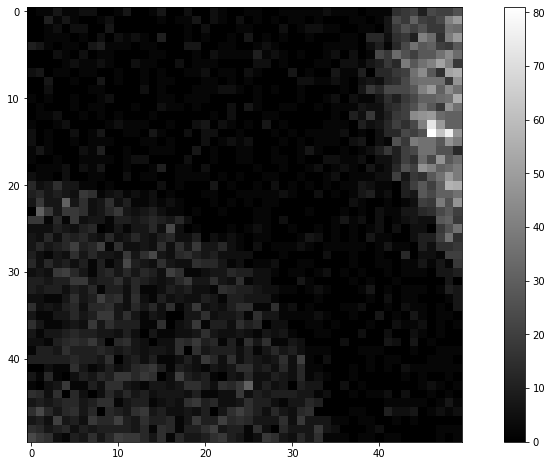

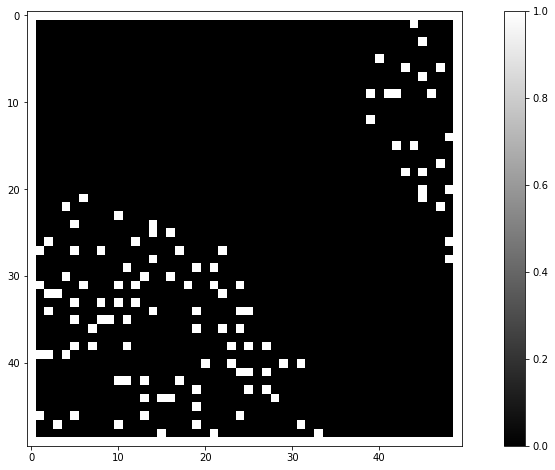

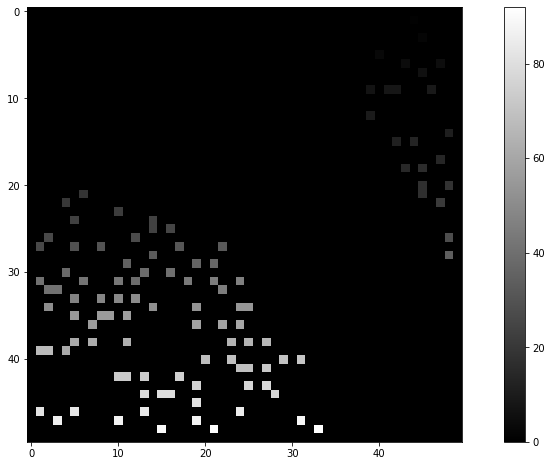

In [86]:
img_small = img[300:350, 400:450]
f.show_image(img_small, 15, 8)
img_r = seeds(img_small, 0.1, 1)
f.show_image(img_r, 15, 8)
img_r = seed_merging(img_r)
f.show_image(img_r, 15, 8)

366
368
368
368
368
369
370
371
370
369
368
368
369
370
371
372
372
372
373
373
374
374
375
376
375
375
375
374
376
378
379
379
379
380
381
380
380
382
381
382
382
382
381
381
380
382
381
380
380
379
379
379
379
378
378
377
376
375
375
374
373
373
373
375
376
376
375
375
374
373
373
373
373
374
373
373
373
375
377
377
376
376
375
375
377
379
378
377
377
379
378
378
380
380
379
378
378
377
377
376
375
376
375
374
373
372
372
372
371
373
372
372
373
373
374
374
374
374
373
373
373
372
373
375
376
375
375
375
374
373
374
375
374
375
374
375
375
376
376
376
378
379
380
382
382
382
381
383
384
386
387
388
387
387
388
389
390
391
393
392
394
396
397
397
397
396
395
394
394
394
393
394
393
392
391
391
390
389
388
387
386
385
385
385
387
386
387
387
388
387
386
386
385
384
384
383
383
384
384
383
383
384
385
385
384
384
385
385
385
386
387
386
386
385
386
386
387
386
385
384
384
383
384
386
386
387
388
390
389
389
390
389
389
388
387
386
387
386
386
386
387
386
386
385
385
385
385
385
385
387


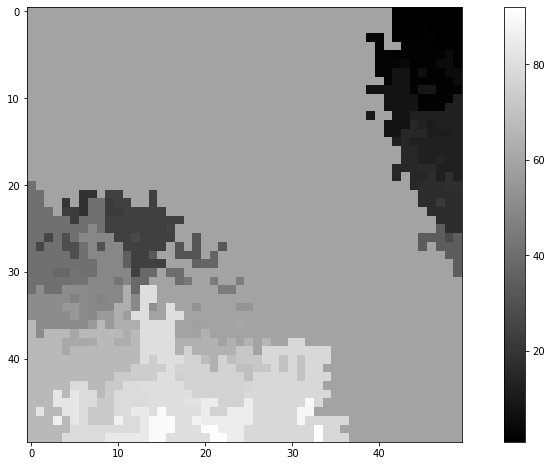

In [87]:
img_r = region_growing(img_small, img_r)
f.show_image(img_r, 15, 8)







In [113]:
#region-merging

def region_distance(img, regions):
    max_region = max(regions.flatten())
    inter_region_distances = np.ones((int(max_region), int(max_region)))
    means = mean_region(img, regions)
    for i in range(0, int(max_region)):
        for j in range(0, int(max_region)):
            if j > i:
                distance = abs(means[i] - means[j]) / (np.amax(img))
                inter_region_distances[i][j] = distance
    return inter_region_distances, means

In [ ]:
def one_merged_region_mean(img, regions, region_number): #img is array of intensity values, regions is array with region numbers, new_pixel is position of last added pixel
    intensity = []
    for p in np.ndindex(img.shape):
        if regions[p] == region_number:
            intensity.append(img[p]) #iterates over every pixel in the image and appends intensity value, if it is in the region
    single_mean = np.mean(intensity) #calculates mean value of region with new pixel
    return single_mean

In [115]:
def region_distance_new(img, regions, pos_min_dist, means):
    max_region = max(regions.flatten())
    inter_region_distances = np.ones((int(max_region), int(max_region)))
    i = pos_min_dist[0] # Regions Nummer 1 die übernommen wird
    means[pos_min_dist[1]] = 500
    means[i] = one_merged_region_mean(img, regions, i)
    means = mean_region(img, regions)
    for j in range(0, int(max_region)): # Regions Nummer 2, die nicht übernommen wird
        if j > i:
            distance = abs(means[i] - means[j]) / (np.amax(img))
            inter_region_distances[i][j] = distance
    return inter_region_distances

In [100]:
def region_merge_by_distance(inter_region_distances, regions, min_distance):
    x = np.where(inter_region_distances == min_distance) #finds minimal distance in array and its position
    pos_min_dist = list(zip(x[0], x[1]))[0] # position of first pixel with minimal distance value
    pos_min_dist = (int(pos_min_dist[0]), int(pos_min_dist[1])) #converting to int for finding in list
    regions[regions == pos_min_dist[1]] = pos_min_dist[0]
    return regions, pos_min_dist

        #for p in np.ndindex(img.shape):
        #    if regions[p] == pos_min_dist[1]:
        #        regions[p] == pos_min_dist[0]

In [110]:
def distance_merging_while(regions, threshold, img):
    result_region_distance = region_distance(img, regions)
    inter_region_distances = result_region_distance[0]
    means = result_region_distance[1]
    min_distance = np.amin(inter_region_distances)
    while min_distance < threshold:
        result_region_merge_by_distance = region_merge_by_distance(inter_region_distances, regions, min_distance)
        regions = result_region_merge_by_distance[0]
        pos_min_dist = result_region_merge_by_distance[1]
        inter_region_distances = region_distance_new(img, regions, pos_min_dist, means)
    return regions


C:\Users\L\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\L\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[[59. 59. 59. ...  1.  1.  1.]
 [59. 59. 59. ...  1.  1.  1.]
 [59. 59. 59. ...  1.  1.  1.]
 ...
 [67. 67. 67. ... 59. 59. 59.]
 [67. 67. 67. ... 59. 59. 59.]
 [67. 67. 67. ... 59. 59. 59.]]


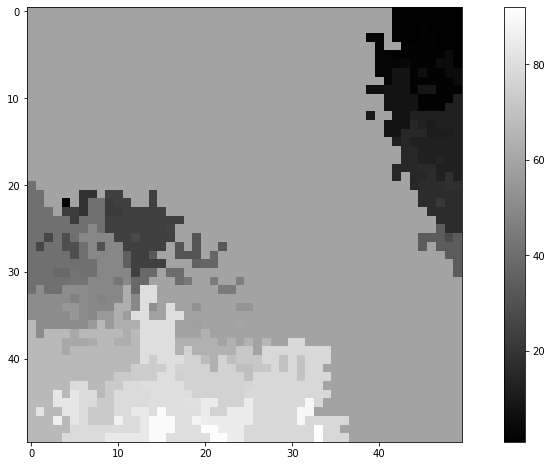

In [124]:
test = distance_merging_while(img_r, 0.000001, img_small)
print(test)
f.show_image(test, 15, 8)